In [1]:
import pickle
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

# Labels

In [2]:
# Create a Polygon
poly = Polygon(shell=[(0, 0), (1, 0), (1, 1), (0, 1), (0, 0)], holes=[[(0.2, 0.2), (0.2, 0.8), (0.8, 0.8), (0.8, 0.2), (0.2, 0.2)]])
print(poly)

POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0), (0.2 0.2, 0.2 0.8, 0.8 0.8, 0.8 0.2, 0.2 0.2))


In [3]:
# Specify the path to the .pkl file
file_path = './resources/sind_labels.pkl'

# Open and load the file
with open(file_path, 'rb') as f:
    data = pickle.load(f)

df = pd.DataFrame(data)
print(df[0].unique())


# Now loaded_object contains the data that was saved in the .pkl file


[3 4 5 2 6 1 0]


# Sind Data

In [4]:
with open('./resources/sind.pkl', 'rb') as f:
    data = pickle.load(f)

data.shape

(273602, 540)

In [5]:
data

array([[ 1.99591103e+01,  2.00319116e+01,  2.00709695e+01, ...,
         6.01647656e-02,  1.91740437e-02, -1.68008170e-02],
       [ 2.00319116e+01,  2.00709695e+01,  2.00960067e+01, ...,
         1.91740437e-02, -1.68008170e-02, -3.06775508e-02],
       [ 2.00709695e+01,  2.00960067e+01,  2.01337267e+01, ...,
        -1.68008170e-02, -3.06775508e-02, -2.44755359e-02],
       ...,
       [ 4.30458502e+00,  4.30220185e+00,  4.29601763e+00, ...,
        -1.57651937e-01, -2.68368959e-01, -3.61668895e-01],
       [ 4.30220185e+00,  4.29601763e+00,  4.29682635e+00, ...,
        -2.68368959e-01, -3.61668895e-01, -4.21821838e-01],
       [ 4.29601763e+00,  4.29682635e+00,  4.30214910e+00, ...,
        -3.61668895e-01, -4.21821838e-01, -4.43442718e-01]])

In [6]:
len(data[0])

#90*6 = 540, 90 is the input_len and 6 are the 6 different variables recorded (x, y, vx. vy, ax. ay)

540

In [7]:
len(data)

# number of people recorded 1656 (-66 exclude 8_02_1 file) multiplied by the avg of (trajectory path - 90)
# if velocity_filter True then exclude data below velocity threshold 

273602

# OSM File

In [8]:
import osmium as osm

class OSMHandler(osm.SimpleHandler):
    def __init__(self):
        osm.SimpleHandler.__init__(self)
        self.nodes = []

    def node(self, n):
        self.nodes.append((n.location.lat, n.location.lon))

handler = OSMHandler()
handler.apply_file('./resources/SinD/Data/mapfile-Tianjin.osm')

In [9]:
handler

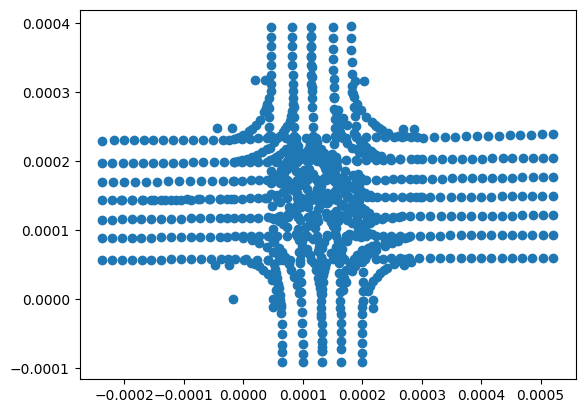

In [10]:
import matplotlib.pyplot as plt

lat, lon = zip(*handler.nodes)
plt.scatter(lon, lat)  # Longitudes and latitudes
plt.show()

['crosswalk_poly', 'gap_poly', 'intersection_poly', 'road_poly', 'sidewalk_poly']
poly:  POLYGON ((16.926022989850026 32.37470159783602, 17.004023061599582 32.34149675483784, 20.670026812294964 32.43004196471985, 21.216027060698252 31.301077905264144, 22.01831333246082 30.360274443037216, 23.043456914427225 29.198105469286, 24.11317205359228 28.39012125348122, 24.893172661191784 27.7481612178233, 25.383458787749987 27.48252254675334, 26.018602187163197 27.183679025599695, 27.077174518432003 26.707743043559457, 28.982604783028364 26.2539434321716, 30.20832017471548 26.110055619390074, 31.434035571001004 26.043645718589378, 31.3783205137006 22.446457093759026, 31.233462689211592 19.258794570952745, 31.20003366196761 16.36997538983169, 31.23346188798314 13.304063835795931, 31.133175779134035 10.182810931011103, 31.066318330122158 6.663100199842754, 30.286317605525255 6.519212696018539, 29.50631687103305 6.275710734240511, 28.626030317682307 5.910457771538054, 28.158029868791346 5.70016060

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


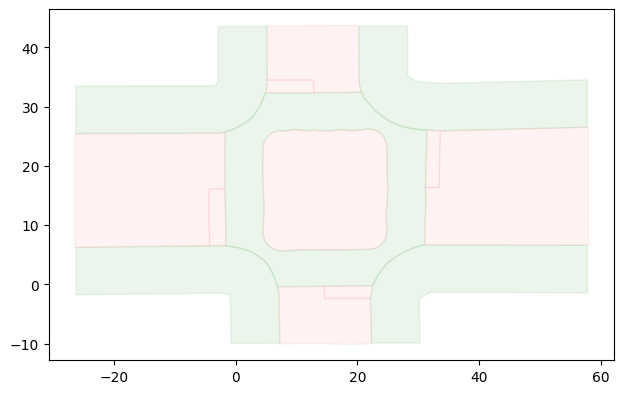

In [11]:
from utils.map import SinD_map

map_instance = SinD_map()
ax, fig = map_instance.plot_areas()
plt.show()

In [12]:
map_instance

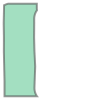

In [13]:
from utils.poly_process import crosswalk_poly_for_label as cpfl

map = SinD_map()
cpfl(map)[0]

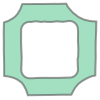

In [14]:
map.crosswalk_poly

# Labeling Function

In [15]:
from shapely.geometry import LineString, Point
import numpy as np
from math import pi
from tqdm import tqdm
import os

In [16]:
ROOT = os.getcwd() + "/resources"
LABELS = {
    "cross_left": 0,
    "cross_right": 1,
    "cross_straight": 2,
    "cross_illegal": 3,
    "crossing_now": 4,
    "not_cross": 5,
    "unknown": 6,
}

In [17]:
def angle_between_angles(a1: float, a2: float):
    """Calculate interior angle between two angles

    Parameters:
    -----------
    a1 : float
        The first heading (angle)
    a2 : float
        The second heading (angle)
    """
    v = np.array([np.cos(a1), np.sin(a1)])
    w = np.array([np.cos(a2), np.sin(a2)])
    return np.math.atan2(np.linalg.det([v, w]), np.dot(v, w))


In [18]:
def labels(
    map,
    data: np.ndarray,
    input_len: int = 30,
    save_data: bool = True,
    disable_progress_bar: bool = False,
):
    _labels = []
    _crosswalks = cpfl(map)
    for _data in tqdm(data, desc="Labeling data", disable=disable_progress_bar):
        _x, _y = _data[0:input_len], _data[input_len : 2 * input_len]
        _l = LineString(list(zip(_x, _y)))
        _avg_angle = np.arctan2(sum(_y[2:6] - _y[0:4]), sum(_x[2:6] - _x[0:4]))
        _avg_angle_end = np.arctan2(
            sum(_y[-6:-2] - _y[-4:]), sum(_x[-6:-2] - _x[-4:])
        )
        if (
            (_l.crosses(_crosswalks[0]) or _l.crosses(_crosswalks[2]))
            and not (
                _l.crosses(map.road_poly)
                or _l.crosses(map.intersection_poly)
                or _l.crosses(map.gap_poly)
            )
            and Point((_x[0], _y[0])).within(map.sidewalk_poly)
        ):
            if (_avg_angle > pi / 4 and _avg_angle < 3 * pi / 4) or (
                _avg_angle > -3 * pi / 4 and _avg_angle < -pi / 4
            ):
                _labels.append(LABELS["cross_straight"])
            elif _avg_angle >= -pi / 4 and _avg_angle <= pi / 4:
                if _y[0] < 16:
                    _labels.append(LABELS["cross_left"])
                elif _y[0] >= 16:
                    _labels.append(LABELS["cross_right"])
            else:
                if _y[0] < 16:
                    _labels.append(LABELS["cross_right"])
                elif _y[0] >= 16:
                    _labels.append(LABELS["cross_left"])
        elif (
            (_l.crosses(_crosswalks[1]) or _l.crosses(_crosswalks[3]))
            and not (
                _l.crosses(map.road_poly)
                or _l.crosses(map.intersection_poly)
                or _l.crosses(map.gap_poly)
            )
            and Point((_x[0], _y[0])).within(map.sidewalk_poly)
        ):
            if (_avg_angle > -pi / 4 and _avg_angle < pi / 4) or (
                _avg_angle > 3 * pi / 4 or _avg_angle < -3 * pi / 4
            ):
                _labels.append(LABELS["cross_straight"])
            elif _avg_angle > pi / 4 and _avg_angle < 3 * pi / 4:
                if _x[0] < 14:
                    _labels.append(LABELS["cross_right"])
                elif _x[0] >= 14:
                    _labels.append(LABELS["cross_left"])
            else:
                if _x[0] < 14:
                    _labels.append(LABELS["cross_left"])
                elif _x[0] >= 14:
                    _labels.append(LABELS["cross_right"])
        elif _l.within(map.crosswalk_poly):
            _labels.append(LABELS["crossing_now"])
        elif _l.within(map.sidewalk_poly):
            _labels.append(LABELS["not_cross"])
        elif (
            _l.intersects(map.road_poly)
            or _l.intersects(map.intersection_poly)
            or _l.intersects(map.gap_poly)
        ):
            _labels.append(LABELS["cross_illegal"])
        elif Point((_x[0], _y[0])).within(map.crosswalk_poly) and not (
            _l.intersects(map.road_poly)
            or _l.intersects(map.intersection_poly)
            or _l.intersects(map.gap_poly)
        ):
            if Point((_x[-1], _y[-1])).within(map.sidewalk_poly):
                _labels.append(LABELS["not_cross"])
            else:
                _labels.append(LABELS["unknown"])
        elif Point((_x[0], _y[0])).within(map.sidewalk_poly) and not (
            _l.intersects(map.road_poly)
            or _l.intersects(map.intersection_poly)
            or _l.intersects(map.gap_poly)
        ):
            if Point((_x[-1], _y[-1])).within(map.crosswalk_poly):
                _angle_diff = angle_between_angles(_avg_angle, _avg_angle_end)
                if np.abs(_angle_diff) < pi / 4 and (
                    (
                        _avg_angle > pi / 4
                        and _avg_angle < 3 * pi / 4
                        and _avg_angle_end > pi / 4
                        and _avg_angle_end < 3 * pi / 4
                    )
                    or (
                        _avg_angle > -3 * pi / 4
                        and _avg_angle < -pi / 4
                        and _avg_angle_end > -3 * pi / 4
                        and _avg_angle_end < -pi / 4
                    )
                    or (
                        _avg_angle > -pi / 4
                        and _avg_angle < pi / 4
                        and _avg_angle_end > -pi / 4
                        and _avg_angle_end < pi / 4
                    )
                    or (
                        (_avg_angle > 3 * pi / 4 or _avg_angle < -3 * pi / 4)
                        and (
                            _avg_angle_end > 3 * pi / 4
                            or _avg_angle_end < -3 * pi / 4
                        )
                    )
                ):
                    _labels.append(LABELS["cross_straight"])
                elif _angle_diff < -pi / 4 and _angle_diff > -3 * pi / 4:
                    _labels.append(LABELS["cross_right"])
                elif _angle_diff > pi / 4 and _angle_diff < 3 * pi / 4:
                    _labels.append(LABELS["cross_left"])
                else:
                    _labels.append(LABELS["unknown"])
            else:
                _labels.append(LABELS["unknown"])
        else:
            _labels.append(LABELS["unknown"])
    if save_data:
        _f = open(ROOT + "/sind_labels.pkl", "wb")
        pickle.dump(np.array(_labels), _f)
    return np.array(_labels)

In [19]:
# from utils.data_reader import SinD
# sind = SinD()
# data = sind.data(input_len=90)

In [20]:
_labels = labels(map, data, 90, False, False)

Labeling data:   0%|          | 612/273602 [00:00<00:44, 6110.94it/s]

Labeling data: 100%|██████████| 273602/273602 [00:42<00:00, 6375.26it/s]


In [21]:
len(_labels)

273602

In [22]:
data.shape

(273602, 540)

# Plot Data

In [23]:
from utils.data_reader import SinD
sind = SinD()

In [24]:
check_id = 10

In [25]:
def plot_dataset(map, pedestrian_data, map_overlay: bool = True, alpha: float = 0.2):
    ax1 = plt.figure(1).add_subplot(projection="3d")
    ax2 = map.plot_areas(alpha=alpha)[0] if map_overlay == True else plt.figure(2).add_subplot()
    ax3 = plt.figure(3).add_subplot(projection="3d")
    for _id in pedestrian_data.keys():
        print(_id)
        x, y = np.array(pedestrian_data[_id]["x"]), np.array(pedestrian_data[_id]["y"])
        vx, vy = pedestrian_data[_id]["vx"], pedestrian_data[_id]["vy"]
        ax, ay = pedestrian_data[_id]["ax"], pedestrian_data[_id]["ay"]
        v = np.sqrt(np.array(vx).T ** 2 + np.array(vy).T ** 2)
        a = np.sqrt(np.array(ax).T ** 2 + np.array(ay).T ** 2)
        ax1.plot(x, y, zs=v, c="r"), ax1.set_title(
            "Velocity profile of trajectories"
        ), ax1.set_xlim(0, 30), ax1.set_ylim(0, 30), ax1.set_zlim(0, 5)
        ax1.set_xlabel('X'), ax1.set_ylabel('Y'), ax1.set_zlabel('V')
        ax2.plot(x, y, c="orange"), ax2.set_title("Pedestrian trajectories")
        ax3.plot(x, y, zs=a, c="r"), ax3.set_title(
            "Acceleration profile of trajectories"
        ), ax3.set_xlim(0, 30), ax3.set_ylim(0, 30), ax3.set_zlim(0, 5)
        ax3.set_xlabel('X'), ax3.set_ylabel('Y'), ax3.set_zlabel('A')
    plt.grid()
    plt.show()

['crosswalk_poly', 'gap_poly', 'intersection_poly', 'road_poly', 'sidewalk_poly']
poly:  POLYGON ((16.926022989850026 32.37470159783602, 17.004023061599582 32.34149675483784, 20.670026812294964 32.43004196471985, 21.216027060698252 31.301077905264144, 22.01831333246082 30.360274443037216, 23.043456914427225 29.198105469286, 24.11317205359228 28.39012125348122, 24.893172661191784 27.7481612178233, 25.383458787749987 27.48252254675334, 26.018602187163197 27.183679025599695, 27.077174518432003 26.707743043559457, 28.982604783028364 26.2539434321716, 30.20832017471548 26.110055619390074, 31.434035571001004 26.043645718589378, 31.3783205137006 22.446457093759026, 31.233462689211592 19.258794570952745, 31.20003366196761 16.36997538983169, 31.23346188798314 13.304063835795931, 31.133175779134035 10.182810931011103, 31.066318330122158 6.663100199842754, 30.286317605525255 6.519212696018539, 29.50631687103305 6.275710734240511, 28.626030317682307 5.910457771538054, 28.158029868791346 5.70016060

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


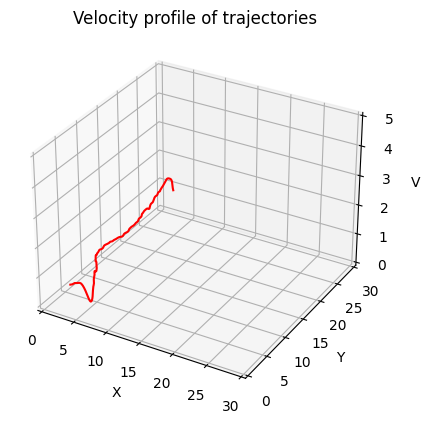

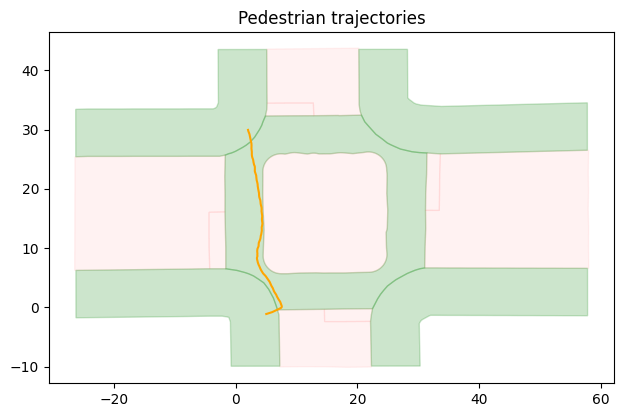

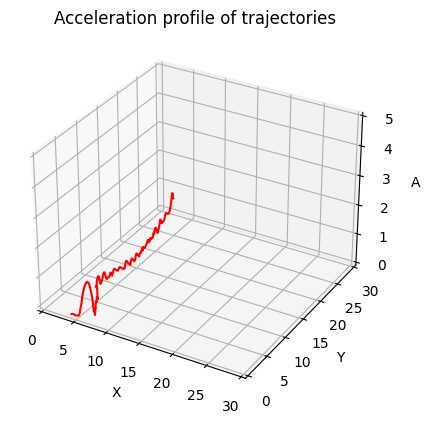

In [26]:
plot_dataset(map, pedestrian_data={check_id: sind.pedestrian_data[check_id]})

In [27]:
print(_labels[check_id])
for key, idx in LABELS.items():
    if idx == _labels[check_id]: print(key)

3
cross_illegal


In [28]:
category_names = {v: k for k, v in LABELS.items()}
named_categories = np.array([category_names[num] for num in _labels])
category_counts = pd.Series(named_categories).value_counts()

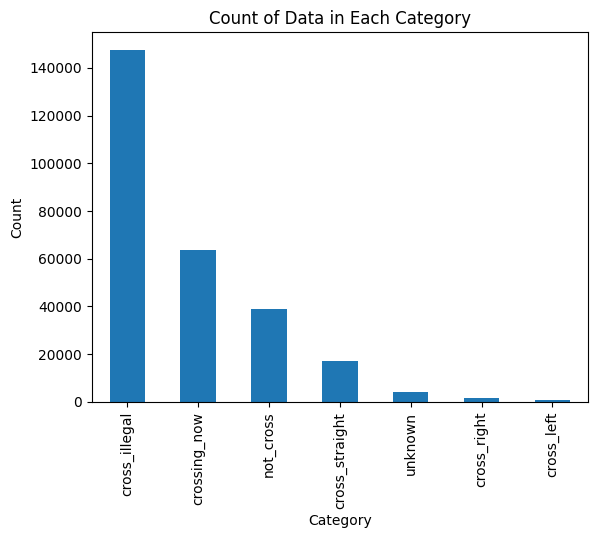

In [29]:
import matplotlib.pyplot as plt

# Create a bar plot
category_counts.plot(kind='bar')

# Add labels and title (optional)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Data in Each Category')

# Show the plot
plt.show()

# Analyze Labels Function

In [30]:
sind.pedestrian_data[10]['y']

3820    29.938210
3821    29.853756
3822    29.741423
3823    29.626017
3824    29.501406
          ...    
4085    -0.976670
4086    -1.010128
4087    -1.036145
4088    -1.073393
4089    -1.111686
Name: y, Length: 270, dtype: float64

['crosswalk_poly', 'gap_poly', 'intersection_poly', 'road_poly', 'sidewalk_poly']
poly:  POLYGON ((16.926022989850026 32.37470159783602, 17.004023061599582 32.34149675483784, 20.670026812294964 32.43004196471985, 21.216027060698252 31.301077905264144, 22.01831333246082 30.360274443037216, 23.043456914427225 29.198105469286, 24.11317205359228 28.39012125348122, 24.893172661191784 27.7481612178233, 25.383458787749987 27.48252254675334, 26.018602187163197 27.183679025599695, 27.077174518432003 26.707743043559457, 28.982604783028364 26.2539434321716, 30.20832017471548 26.110055619390074, 31.434035571001004 26.043645718589378, 31.3783205137006 22.446457093759026, 31.233462689211592 19.258794570952745, 31.20003366196761 16.36997538983169, 31.23346188798314 13.304063835795931, 31.133175779134035 10.182810931011103, 31.066318330122158 6.663100199842754, 30.286317605525255 6.519212696018539, 29.50631687103305 6.275710734240511, 28.626030317682307 5.910457771538054, 28.158029868791346 5.70016060

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


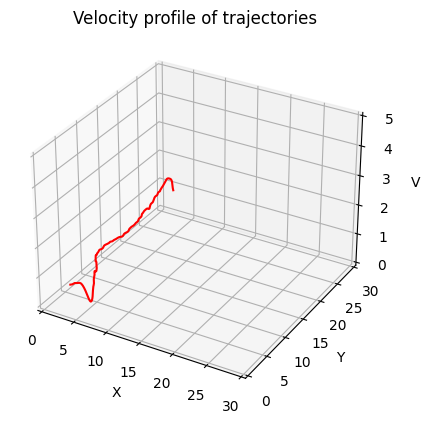

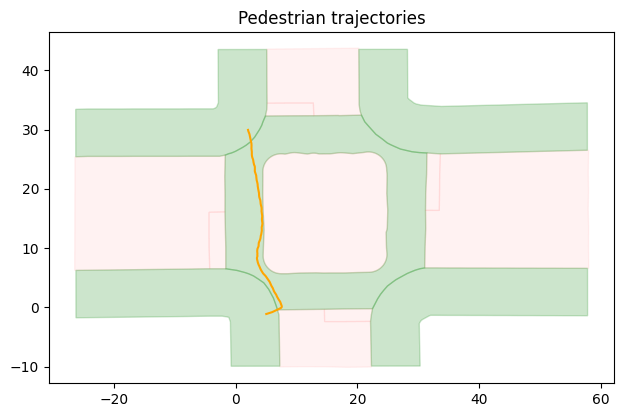

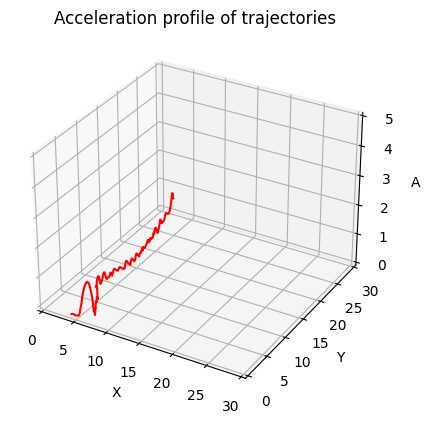

In [31]:
plot_dataset(map, pedestrian_data={10: sind.pedestrian_data[10]})

In [32]:
data[0].shape

(540,)

In [33]:
_data = data[10*(0-90)]
input_len = 90

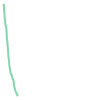

In [34]:
_x, _y = _data[0:input_len], _data[input_len : 2 * input_len]
LineString(list(zip(_x, _y)))

In [35]:
Point((_x[0], _y[0])).within(map.sidewalk_poly)

False

In [36]:
_avg_angle = np.arctan2(sum(_y[2:6] - _y[0:4]), sum(_x[2:6] - _x[0:4]))
_avg_angle

-1.5073128557623015

In [37]:
_avg_angle_end = np.arctan2(
                sum(_y[-6:-2] - _y[-4:]), sum(_x[-6:-2] - _x[-4:])
            )
_avg_angle_end

1.9876655779664225

In [38]:
len(_y), len(_y[2:6]), len(_y[0:4]), len(_y[-6:-2]), len(_y[-4:])

(90, 4, 4, 4, 4)

In [39]:
_y[0:4], _y[2:6]

(array([16.07811027, 15.94797582, 15.81489639, 15.66297671]),
 array([15.81489639, 15.66297671, 15.50950071, 15.35817432]))

In [40]:
_y[-6:-2], _y[-4:]

(array([3.79361058, 3.67551898, 3.55817998, 3.44109101]),
 array([3.55817998, 3.44109101, 3.32401569, 3.20685616]))

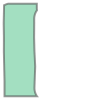

In [41]:
_crosswalks = cpfl(map)
_crosswalks[0]

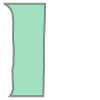

In [42]:
_crosswalks[2]

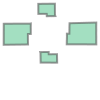

In [43]:
map.road_poly

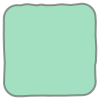

In [44]:
map.intersection_poly

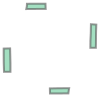

In [45]:
map.gap_poly

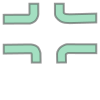

In [46]:
map.sidewalk_poly

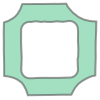

In [47]:
map.crosswalk_poly

In [48]:
Point((_x[0], _y[0])).within(map.sidewalk_poly[3]), Point((_x[0], _y[0])).touches(map.sidewalk_poly[3])

/tmp/ipykernel_84909/1762231741.py:1: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  Point((_x[0], _y[0])).within(map.sidewalk_poly[3]), Point((_x[0], _y[0])).touches(map.sidewalk_poly[3])


(False, False)

In [49]:
Point((_x[0], _y[0])).coords[0]

(0.607688395028568, 16.0781102748493)

['crosswalk_poly', 'gap_poly', 'intersection_poly', 'road_poly', 'sidewalk_poly']
poly:  POLYGON ((16.926022989850026 32.37470159783602, 17.004023061599582 32.34149675483784, 20.670026812294964 32.43004196471985, 21.216027060698252 31.301077905264144, 22.01831333246082 30.360274443037216, 23.043456914427225 29.198105469286, 24.11317205359228 28.39012125348122, 24.893172661191784 27.7481612178233, 25.383458787749987 27.48252254675334, 26.018602187163197 27.183679025599695, 27.077174518432003 26.707743043559457, 28.982604783028364 26.2539434321716, 30.20832017471548 26.110055619390074, 31.434035571001004 26.043645718589378, 31.3783205137006 22.446457093759026, 31.233462689211592 19.258794570952745, 31.20003366196761 16.36997538983169, 31.23346188798314 13.304063835795931, 31.133175779134035 10.182810931011103, 31.066318330122158 6.663100199842754, 30.286317605525255 6.519212696018539, 29.50631687103305 6.275710734240511, 28.626030317682307 5.910457771538054, 28.158029868791346 5.70016060

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


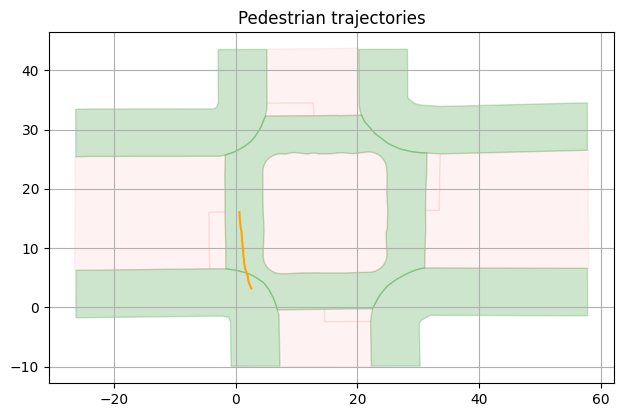

In [50]:
ax2 = map.plot_areas(alpha=0.2)[0] 
ax2.plot(_x, _y, c="orange"), ax2.set_title("Pedestrian trajectories")

plt.grid()
plt.show()